# ViT + BERT

## Import Library

In [1]:
pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.bleu.bleu import Bleu
import os
import zipfile

## Data Preparation

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

class ImageCaptionDataset(Dataset):
    def __init__(self, text_df, tokenizer, image_height, image_width, augment=True):
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        self.augment = augment
        
        # Define Albumentations transforms
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.ColorJitter(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
            A.HueSaturationValue(p=0.3),
            A.Resize(self.image_height, self.image_width),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True)
            # ToTensorV2()  # Convert to PyTorch tensor
        ])
        
        self.val_transforms = A.Compose([
            A.Resize(self.image_height, self.image_width),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True)
            # ToTensorV2()
        ])

    def __len__(self):
        return len(self.text_df)
    
    def __getitem__(self, index):
        image_filename = self.text_df.iloc[index]['image']
        
        # Load image
        image = Image.open(image_filename).convert("RGB")
        image = np.array(image)  # Convert PIL image to numpy array
        
        # Apply Albumentations transforms
        if self.augment:
            transformed = self.train_transforms(image=image)
        else:
            transformed = self.val_transforms(image=image)
        
        image = transformed["image"]  # Extract transformed image tensor
        # Resize and convert to numpy array
        image = np.array(image)
        image = torch.tensor(np.moveaxis(image, -1, 0))  # Convert HWC to CHW (PyTorch format)
        
        # Tokenize caption
        caption_token = self.tokenizer(
            self.text_df.iloc[index]['caption'], 
            add_special_tokens=True, 
            padding="max_length", 
            max_length=32, 
            truncation=True
        ).input_ids 
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]
        
        return {"pixel_values": image, "caption_token": torch.tensor(caption_token)}


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# path to images

coco_train_images = "/kaggle/input/coco-2017-dataset/coco2017/train2017/"
coco_val_images = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

In [5]:
# Load image and caption Dataframe

train_df = pd.read_csv("/kaggle/input/coco-df/df_coco_train_complete.csv", index_col=False)
# train_df.drop('Unnamed: 0', axis=1, inplace=True)

val_df = pd.read_csv("/kaggle/input/coco-df/df_coco_val_complete.csv", index_col=False)
# val_df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
train_df.head()

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/train...   
1  /kaggle/input/coco-2017-dataset/coco2017/train...   
2  /kaggle/input/coco-2017-dataset/coco2017/train...   
3  /kaggle/input/coco-2017-dataset/coco2017/train...   
4  /kaggle/input/coco-2017-dataset/coco2017/train...   

                                             caption  
0  A white boom box with an mp3 player on top of it.  
1    Young kid swings bat at  baseball in the flied   
2       Two beach chairs and an umbrella on a beach.  
3  A close up of a street pole with no parking si...  
4  A woman with glasses eats a hot dog in a bleac...

In [7]:
val_df.head()

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/val20...   
1  /kaggle/input/coco-2017-dataset/coco2017/val20...   
2  /kaggle/input/coco-2017-dataset/coco2017/val20...   
3  /kaggle/input/coco-2017-dataset/coco2017/val20...   
4  /kaggle/input/coco-2017-dataset/coco2017/val20...   

                                             caption  
0  A pizza covered in lots of greens on top of a ...  
1  Two giraffe standing in a green grass covered ...  
2  An assortment of doughnuts are arranged in a d...  
3           A woman flies a kite near a young child.  
4  A woman sits on a chair and watches a vintage TV.

## Vision Encoder Decoder Models

In [8]:
# # Setting up model

# from PIL import Image
# import requests

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# if decoder_tokenizer.pad_token is None:
#     decoder_tokenizer.pad_token = '[PAD]'

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224", "bert-base-uncased")

# model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
# model.config.pad_token_id = decoder_tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [9]:
# Load trained model

model_path = "/kaggle/input/vit-bert-pretrained/vit_bert_last (6)/vit_bert_model"

# File paths inside the model directory
config_file = f"{model_path}/config.json"
special_tokens_map = f"{model_path}/special_tokens_map.json"
tokenizer_file = f"{model_path}/tokenizer.json"
vocab_file = f"{model_path}/vocab.txt"
model_weights = f"{model_path}/pytorch_model.bin"


In [10]:
# Load the trained model
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# Load the tokenizer for the decoder (BERT tokenizer)
decoder_tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the image processor for the encoder
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Ensure pad token is set
if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.pad_token = '[PAD]'

# Update model config
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

print("Model, tokenizer, and image processor loaded successfully!")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Model, tokenizer, and image processor loaded successfully!


In [11]:
# Create datasets and dataloaders

train_dataset = ImageCaptionDataset(text_df=train_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224, augment=True)
val_dataset = ImageCaptionDataset(text_df=val_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224, augment=True)

In [12]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=3)

In [13]:
len(train_dataloader)

15625

## Training Setup

In [14]:
# Set up training
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import OneCycleLR

optimizer = Adam(model.parameters(), lr=1e-5)

from transformers import get_scheduler
epochs = 10
num_training_steps = epochs * len(train_dataloader)
# lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )
scheduler = OneCycleLR(optimizer, max_lr=1e-5, total_steps=num_training_steps)

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens during loss computation

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)

model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [15]:
# zip file
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [ ]:
def evaluate_validation_loss_cross_entropy(model, val_dataloader, criterion, device):
    """Evaluate validation loss using Cross Entropy Loss."""
    model.eval()  # Set model to evaluation mode
    val_losses = []  # Track losses on validation set

    with torch.no_grad():  # Disable gradient computation
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])
            
            # Get logits and reshape for CrossEntropyLoss
            logits = outputs.logits  # Shape: [batch_size, sequence_length, vocab_size]
            target = batch['caption_token']  # Shape: [batch_size, sequence_length]

            # Reshape logits for CrossEntropyLoss: [batch_size * sequence_length, vocab_size]
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)  # Reshape target to match: [batch_size * sequence_length]

            loss = criterion(logits, target)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    return avg_val_loss

# Train loop
model.train()
for epoch in range(epochs):
    epoch_losses = []  # Track losses for the current epoch

    print(f"Starting Epoch {epoch+1}/{epochs}")
    
    for batch_idx, batch in enumerate(train_dataloader, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])
        
        # Get logits and reshape for CrossEntropyLoss
        logits = outputs.logits  # Shape: [batch_size, sequence_length, vocab_size]
        target = batch['caption_token']  # Shape: [batch_size, sequence_length]

        # Reshape logits for CrossEntropyLoss: [batch_size * sequence_length, vocab_size]
        logits = logits.view(-1, logits.size(-1))
        target = target.view(-1)  # Reshape target to match: [batch_size * sequence_length]

        # Compute loss
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Track batch loss
        epoch_losses.append(loss.item())

        if batch_idx % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    # Calculate and print the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Compute validation loss using Cross Entropy Loss
    avg_val_loss = evaluate_validation_loss_cross_entropy(model, val_dataloader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Save the model at the end of the epoch
    save_directory = "vit_bert_model"
    model.save_pretrained(save_directory)
    decoder_tokenizer.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

    with zipfile.ZipFile('vit_bert_last.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir('/kaggle/working/vit_bert_model', zipf)
    
    print("Model folder has been zipped to vit_bert_last.zip.")


Starting Epoch 1/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1, Batch 1000/15625, Loss: 1.3277
Epoch 1, Batch 2000/15625, Loss: 1.4518
Epoch 1, Batch 3000/15625, Loss: 1.5085
Epoch 1, Batch 4000/15625, Loss: 1.6528
Epoch 1, Batch 5000/15625, Loss: 1.3305
Epoch 1, Batch 6000/15625, Loss: 1.4765
Epoch 1, Batch 7000/15625, Loss: 1.5583
Epoch 1, Batch 8000/15625, Loss: 1.3241
Epoch 1, Batch 9000/15625, Loss: 1.5170
Epoch 1, Batch 10000/15625, Loss: 1.3233
Epoch 1, Batch 11000/15625, Loss: 1.3361
Epoch 1, Batch 12000/15625, Loss: 1.5804
Epoch 1, Batch 13000/15625, Loss: 1.3517
Epoch 1, Batch 14000/15625, Loss: 1.3810
Epoch 1, Batch 15000/15625, Loss: 1.4173
Epoch 1/10, Average Loss: 1.4409
Epoch 1/10, Validation Loss: 1.8048
Model saved to vit_bert_model
Model folder has been zipped to vit_bert_last.zip.
Starting Epoch 2/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2, Batch 1000/15625, Loss: 1.3422
Epoch 2, Batch 2000/15625, Loss: 1.4505
Epoch 2, Batch 3000/15625, Loss: 1.5243
Epoch 2, Batch 4000/15625, Loss: 1.3393
Epoch 2, Batch 5000/15625, Loss: 1.3071
Epoch 2, Batch 6000/15625, Loss: 1.3918
Epoch 2, Batch 7000/15625, Loss: 1.2123
Epoch 2, Batch 8000/15625, Loss: 1.3257
Epoch 2, Batch 9000/15625, Loss: 1.5269
Epoch 2, Batch 10000/15625, Loss: 1.3270
Epoch 2, Batch 11000/15625, Loss: 1.2888
Epoch 2, Batch 12000/15625, Loss: 1.2771
Epoch 2, Batch 13000/15625, Loss: 1.2975
Epoch 2, Batch 14000/15625, Loss: 1.2841
Epoch 2, Batch 15000/15625, Loss: 1.2922
Epoch 2/10, Average Loss: 1.2908
Epoch 2/10, Validation Loss: 1.8557
Model saved to vit_bert_model
Model folder has been zipped to vit_bert_last.zip.
Starting Epoch 3/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3, Batch 1000/15625, Loss: 1.0928
Epoch 3, Batch 2000/15625, Loss: 1.2741
Epoch 3, Batch 3000/15625, Loss: 1.2197
Epoch 3, Batch 4000/15625, Loss: 1.2729
Epoch 3, Batch 5000/15625, Loss: 1.6045
Epoch 3, Batch 6000/15625, Loss: 1.3584
Epoch 3, Batch 7000/15625, Loss: 1.2392
Epoch 3, Batch 8000/15625, Loss: 1.4709
Epoch 3, Batch 9000/15625, Loss: 1.1875
Epoch 3, Batch 10000/15625, Loss: 1.2392
Epoch 3, Batch 11000/15625, Loss: 1.2074
Epoch 3, Batch 12000/15625, Loss: 1.3183
Epoch 3, Batch 13000/15625, Loss: 1.4880
Epoch 3, Batch 14000/15625, Loss: 1.3107


## Evaluation

In [17]:
# Uninstall the previous installed nltk library
!pip install -U nltk

# This upgraded nltkto version 3.5 in which meteor_score is there.
!pip install nltk==3.5

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.9 MB/s eta 0:00:0000:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=48eb85feb0f329f7eb42e5112f4b16deac191da9cf1158349efebe997fc8e297
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
     

In [18]:
grouped_val_df = val_df.groupby('image')['caption'].apply(list).reset_index()
grouped_val_df.head()

image  \
0  /kaggle/input/coco-2017-dataset/coco2017/val20...   
1  /kaggle/input/coco-2017-dataset/coco2017/val20...   
2  /kaggle/input/coco-2017-dataset/coco2017/val20...   
3  /kaggle/input/coco-2017-dataset/coco2017/val20...   
4  /kaggle/input/coco-2017-dataset/coco2017/val20...   

                                             caption  
0  [A person standing at a table in a room., A li...  
1  [Closeup of a brown bear sitting in a grassy a...  
2  [This room has a bed with blue sheets and a la...  
3  [A stop sign installed upside down on a street...  
4  [Three teddy bears, each a different color, sn...

In [19]:
def generate_caption(image, model, tokenizer, device):
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    encoder_output = model.encoder(pixel_values=image)
    
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []
    
    max_length = 32
    
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    # plt.figure(figsize=(4, 4))
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
    # print("Generated Caption:", generated_caption)
    
    return generated_caption

In [20]:
import re
from tqdm import tqdm

# Function to clean and tokenize text
def clean_and_tokenize(text):
    """
    Cleans text by removing special characters and tokenizing.
    """
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    return text.lower().split()  # Convert to lowercase and split into tokens

# Create a lookup map for val_dataset based on image paths
image_to_index_map = {val_dataset.text_df.iloc[i]["image"]: i for i in range(len(val_dataset))}

# Initialize references and predictions
references = []  # List of lists of reference captions
predictions = []  # List of predicted captions

# Iterate through all entries in grouped_val_df
for _, row in tqdm(grouped_val_df.iterrows(), total=len(grouped_val_df), desc="Generating Captions"):
    # Get the ground truth captions
    reference_captions = row["caption"]  # Assumes `grouped_val_df` has a `captions` column
    image_path = row["image"]  # Assuming grouped_val_df includes an `image` column
    
    # Find the corresponding index in val_dataset
    if image_path not in image_to_index_map:
        raise ValueError(f"Image path {image_path} not found in dataset.")
    
    dataset_index = image_to_index_map[image_path]
    dataset_item = val_dataset[dataset_index]
    pixel_values = dataset_item["pixel_values"].numpy()
    
    # Generate the predicted caption
    pred_caption = generate_caption(
        image=pixel_values,
        model=model,
        tokenizer=decoder_tokenizer,
        device=device
    )
    
    # Append references and prediction
    references.append([clean_and_tokenize(ref) for ref in reference_captions])  # Cleaned and tokenized references
    predictions.append(clean_and_tokenize(pred_caption))  # Cleaned and tokenized prediction


Generating Captions: 100%|██████████| 5000/5000 [22:10<00:00,  3.76it/s]


In [53]:
def preview_results(pred_result, valid_result, num_samples=5):
    """
    Print a preview of the predicted and reference captions.

    Args:
    - pred_result: List of predicted captions (tokenized).
    - valid_result: List of reference captions (tokenized, with 5 references each).
    - num_samples: Number of samples to preview.

    Returns:
    - None
    """
    print("\n=== Preview of Predictions and References ===")
    for i, (pred, refs) in enumerate(zip(pred_result, valid_result)):
        if i >= num_samples:
            break
        print(f"Sample {i + 1}:")
        print(f"  Predicted: {' '.join(pred)}")
        print("  References:")
        for j, ref in enumerate(refs):
            print(f"    {j + 1}: {' '.join(ref)}")
        print()
        
preview_results(predictions, references, num_samples=10)


=== Preview of Predictions and References ===
Sample 1:
  Predicted: a living room with a couch chairs table and a television
  References:
    1: a person standing at a table in a room
    2: a living area with a television and a table
    3: a room with chairs a table and a woman in it
    4: a woman stands in the dining area at the table
    5: a woman standing in a kitchen by a window

Sample 2:
  Predicted: a brown bear is sitting in the grass
  References:
    1: closeup of a brown bear sitting in a grassy area
    2: the large brown bear has a black nose
    3: a close up picture of a brown bears face
    4: a big burly grizzly bear is show with grass in the background
    5: a large bear that is sitting on grass

Sample 3:
  Predicted: a bedroom with a bed desk and a window
  References:
    1: this room has a bed with blue sheets and a large bookcase
    2: bedroom scene with a bookcase blue comforter and window
    3: a bedroom with a bookshelf full of books
    4: a bed roo

In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from collections import Counter
from math import log, sqrt
import numpy as np

def calculate_cider(predicted, references):
    """
    Calculate CIDEr score for a single predicted caption and its references.
    CIDEr uses TF-IDF weighting for n-gram similarity.
    """
    def generate_ngrams(tokens, n):
        return [' '.join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

    cider_score = 0.0
    n = 4  # CIDEr typically uses up to 4-grams

    for k in range(1, n+1):
        pred_kgrams = generate_ngrams(predicted, k)
        ref_kgrams = [generate_ngrams(ref, k) for ref in references]
        
        pred_tf = Counter(pred_kgrams)
        ref_tf = Counter([gram for ref in ref_kgrams for gram in ref])

        def compute_tfidf(tf, doc_tf, n_docs):
            return {gram: tf[gram] * log(n_docs / (1 + doc_tf[gram])) for gram in tf}

        pred_tfidf = compute_tfidf(pred_tf, ref_tf, len(references))
        ref_tfidf = compute_tfidf(ref_tf, ref_tf, len(references))

        overlap = set(pred_tfidf.keys()) & set(ref_tfidf.keys())
        numerator = sum(pred_tfidf[gram] * ref_tfidf[gram] for gram in overlap)
        denominator = sqrt(sum(v**2 for v in pred_tfidf.values())) * \
                      sqrt(sum(v**2 for v in ref_tfidf.values()))

        cider_score += numerator / denominator if denominator > 0 else 0.0

    return cider_score / n

def calculate_rouge_l(predicted, references):
    """
    Calculate ROUGE-L score for a single predicted caption and its references.
    """
    def lcs_length(x, y):
        dp = [[0] * (len(y) + 1) for _ in range(len(x) + 1)]
        for i in range(1, len(x) + 1):
            for j in range(1, len(y) + 1):
                if x[i-1] == y[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[-1][-1]

    rouge_l_scores = []
    for ref in references:
        lcs = lcs_length(predicted, ref)
        precision = lcs / len(predicted) if len(predicted) > 0 else 0
        recall = lcs / len(ref) if len(ref) > 0 else 0
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0
        rouge_l_scores.append(f1)

    return max(rouge_l_scores)  # Use the best matching reference

def evaluate(pred_result, valid_result):
    """
    Evaluate predictions using BLEU-1 to BLEU-4, CIDEr, METEOR, and ROUGE-L scores.

    Args:
    - pred_result: List of tokenized predicted captions.
    - valid_result: List of lists of tokenized reference captions (each sublist has 5 references).

    Returns:
    - Dictionary with BLEU-1, BLEU-2, BLEU-3, BLEU-4, CIDEr, METEOR, and ROUGE-L scores.
    """
    smoothing_function = SmoothingFunction().method1
    bleu_scores = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
    cider_scores = []
    meteor_scores = []
    rouge_l_scores = []

    for pred, refs in zip(pred_result, valid_result):
        bleu_scores['BLEU-1'].append(sentence_bleu(refs, pred, weights=(1, 0, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-2'].append(sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-3'].append(sentence_bleu(refs, pred, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-4'].append(sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function))

        cider_scores.append(calculate_cider(pred, refs))
        meteor_scores.append(meteor_score([' '.join(ref) for ref in refs], ' '.join(pred)))
        rouge_l_scores.append(calculate_rouge_l(pred, refs))

    avg_scores = {
        'BLEU-1': np.mean(bleu_scores['BLEU-1']),
        'BLEU-2': np.mean(bleu_scores['BLEU-2']),
        'BLEU-3': np.mean(bleu_scores['BLEU-3']),
        'BLEU-4': np.mean(bleu_scores['BLEU-4']),
        'CIDEr': np.mean(cider_scores),
        'METEOR': np.mean(meteor_scores),
        'ROUGE-L': np.mean(rouge_l_scores)
    }

    return avg_scores


In [22]:
scores = evaluate(predictions, references)
print("Evaluation Scores:", scores)

Evaluation Scores: {'BLEU-1': 0.7237308253298428, 'BLEU-2': 0.5512701892141336, 'BLEU-3': 0.3956165829177088, 'BLEU-4': 0.2806167256557582, 'CIDEr': 0.1745647056674193, 'METEOR': 0.5022787105534835, 'ROUGE-L': 0.5459788163445995}


## Generating Captions

In [76]:
def generate_caption_with_image(image, model, tokenizer, device):
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    encoder_output = model.encoder(pixel_values=image)
    
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []
    
    max_length = 32
    
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption

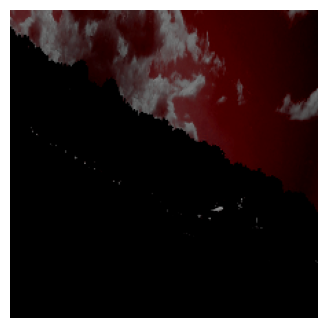

Generated Caption: a large boat is docked in the water.


In [77]:
# generate sample caption for train dataset
pred_caption = generate_caption_with_image(
    image=val_dataset.__getitem__(20)['pixel_values'].numpy(),
    model=model,
    tokenizer=decoder_tokenizer,
    device=device
)

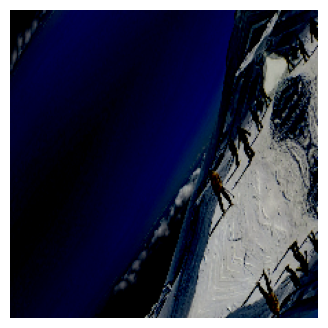

Generated Caption: a group of people riding skis on a snowy slope


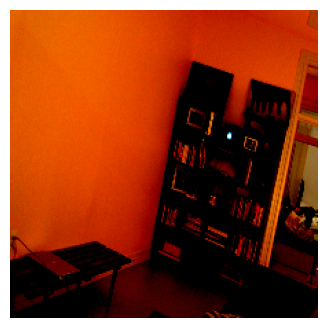

Generated Caption: a living room with a book shelf and a couch.


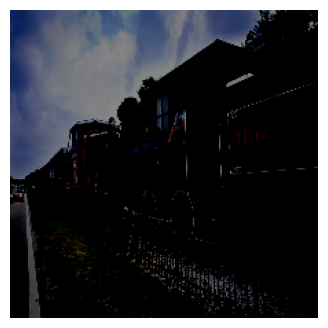

Generated Caption: a train is parked on the side of the road.


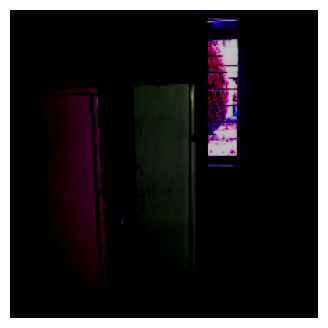

Generated Caption: a refrigerator and a table in a room.


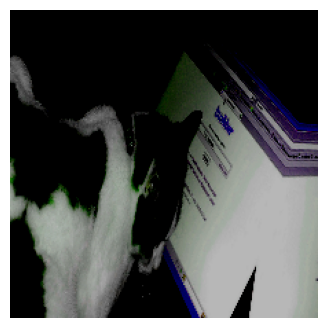

Generated Caption: , a cat is laying on a laptop


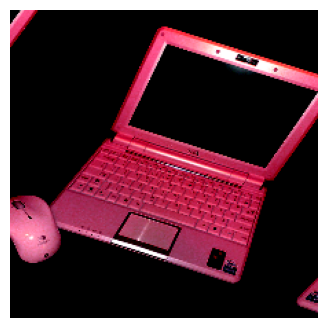

Generated Caption: with one side of the laptop, the other part of the laptop is open.


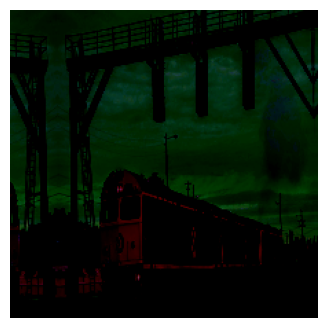

Generated Caption: a train is on the tracks under a bridge.


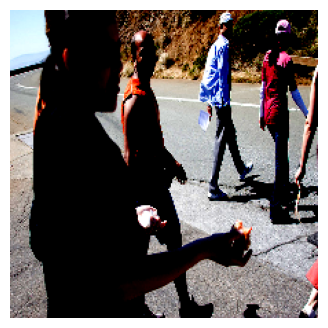

Generated Caption: a man is holding a hot dog and a beer


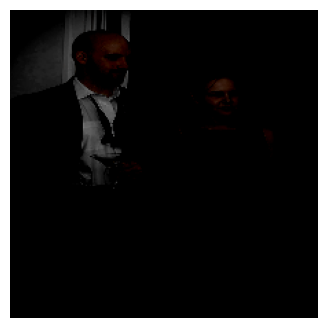

Generated Caption: a man and a woman standing next to each other.


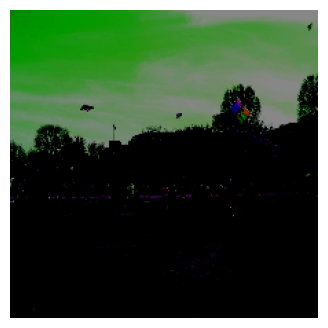

Generated Caption: a group of people flying kites in a park.


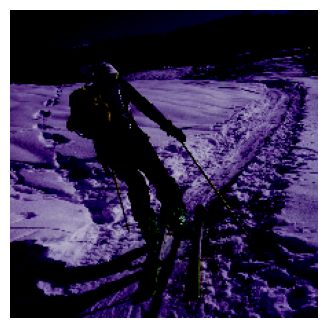

Generated Caption: a man riding skis down a snow covered slope.


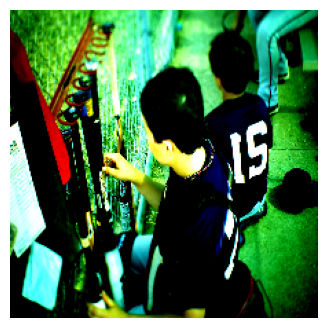

Generated Caption: a boy sitting on a chair with a remote control in his hand.


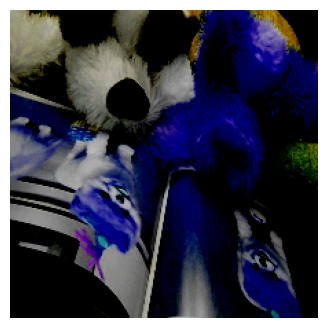

Generated Caption: a stuffed animal is holding a book.


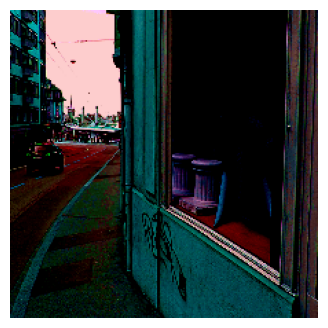

Generated Caption: a large elephant statue is in a window.


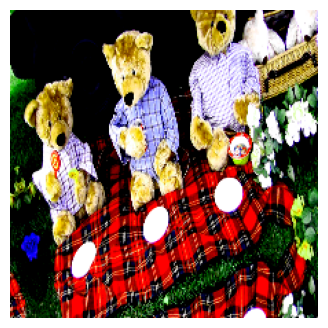

Generated Caption: a group of teddy bears sitting on a blanket.


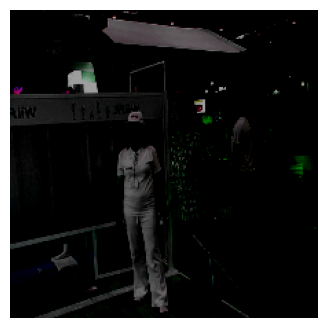

Generated Caption: a woman standing next to a man holding a remote.


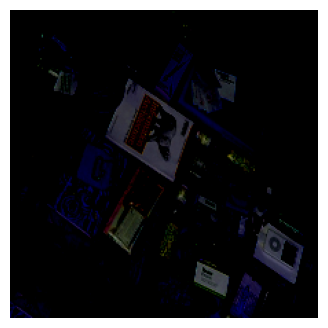

Generated Caption: a variety of items are spread out on a table.


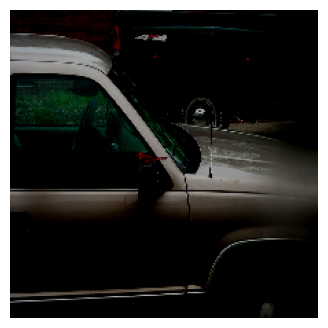

Generated Caption: a dog is sitting in the back of a truck.


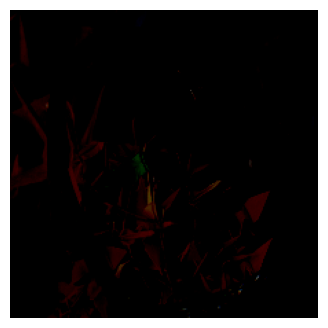

Generated Caption: a glass bowl with a bunch of colorful flowers in it.


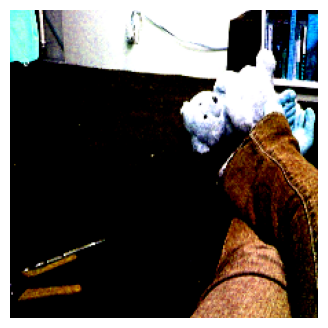

Generated Caption: a person laying on the ground next to a pile of shoes.


In [78]:
# generate sample of train dataset
for index in np.random.randint(int(val_df.shape[0]/4 - 1),size=20):
    pred_caption = generate_caption_with_image( image=val_dataset.__getitem__(index)['pixel_values'].numpy(), model=model , tokenizer=decoder_tokenizer ,
    device=device )

***